# 構成

- 画像を音楽に変換するプログラム. 
- defの集まり > main という構成. 
- 音楽制作はmelodyとloop(の繰り返し)の2種類で構成している. 

## 課題
- 音色の充実
- エフェクトの作成
- 画像解析(顔認識など)の利用
- 機械学習の利用
- うなり機能の追加
- ループの変化
- 再分解して和音を作る -> 分解解像度を注意する必要が出てくる. 2音が最低和音数. 3音での和音にするためには分割をどうするか?
- ampにゆらぎを加える
- 1/fゆらぎ: power = 1/freq

# Def /////////////////////////////////////////////////

In [1]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
from itertools import chain, zip_longest
import random
import time
import math
import wave
import struct
import random
from definitions import partition1d, partition2d, to_mean, hsv2rgb, rgb2hsv
from definitions import make_all_candidate, dont_back, select_available, decide_next, decide_shift, jump_unknown
from definitions import mk_reduced_color_img, normalize1d, path_array
from definitions import mk_reduced_rgb, mk_reduced_hsv
from definitions import img2path
from definitions import makewave, wavwrite
from definitions import ampFn, waveFn, set_key, value2freq, unify1d, value2first_time, value2time_length
from definitions import path2wave

# Main ///////////////////////////////////////////////////////////

In [2]:
start_whole_time = time.time()
sr = 44100 # sampling rate

## read image

(1088, 862, 3)


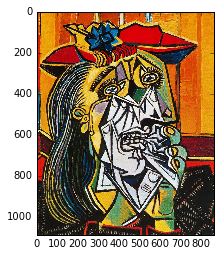

In [3]:
#img = cv2.imread("../../_fig/_others/keitasumiya.jpg")
#img_name = "ks"
img = cv2.imread("../../_fig/picasso/crying_woman.jpg")
img_name = "picasso"
#img = cv2.imread("../../_fig/goch/cafe_terrace_at_night.jpg")
#img_name = "goch"
#img = cv2.imread("../../_fig/_others/miporin.jpg")
#img_name = "miporin"
#img = cv2.imread("../../_fig/_others/miporin_face.jpg")
#img_name = "miporin_face"
#img = cv2.imread("../../_fig/monet/woman_withparasol.jpg")
#img_name = "monet"
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
#height, width, channels = img.shape
print(img.shape)
plt.imshow(img)

## melody part  --------------------------------------
### image

In [4]:
partition_num_width = 10
partition_num_height = 10
last_path_order = 100
first_shift = 1
repeatable_num = 3

log_id, reduced_rgb, reduced_hsv = img2path(img, partition_num_width, partition_num_height, last_path_order, first_shift, repeatable_num)

(10, 10, 3)
(10, 10, 3)


In [5]:
print(log_id)

[[5, 5], [5, 4], [6, 4], [6, 5], [6, 6], [5, 6], [5, 7], [6, 7], [6, 6], [6, 4], [4, 4], [5, 4], [5, 6], [3, 6], [2, 6], [1, 6], [1, 5], [1, 4], [1, 3], [2, 3], [2, 4], [1, 4], [1, 6], [1, 8], [1, 7], [1, 6], [1, 3], [1, 5], [1, 7], [3, 7], [4, 7], [5, 7], [7, 7], [6, 7], [6, 5], [6, 3], [6, 4], [6, 7], [3, 7], [5, 7], [5, 4], [2, 4], [4, 4], [6, 4], [6, 8], [6, 7], [2, 7], [2, 6], [2, 8], [2, 7], [4, 7], [4, 5], [4, 4], [4, 7], [1, 7], [1, 4], [4, 4], [4, 8], [4, 7], [8, 7], [7, 7], [5, 7], [1, 7], [1, 3], [1, 6], [5, 6], [2, 6], [2, 3], [2, 5], [2, 6], [6, 6], [3, 6], [5, 6], [7, 1], [7, 0], [8, 0], [9, 0], [9, 1], [9, 2], [9, 3], [9, 4], [9, 5], [8, 5], [7, 5], [6, 5], [6, 2], [6, 3], [6, 5], [2, 5], [2, 7], [5, 1], [5, 2], [5, 3], [5, 4], [1, 4], [1, 8], [4, 1], [3, 1], [3, 2], [3, 3], [2, 3]]


40


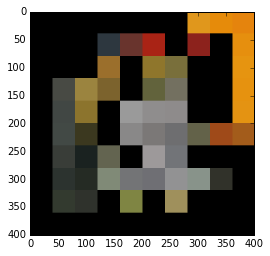

In [6]:
img_size = 400 # pixel
reduced_color_img = mk_reduced_color_img(img_size, partition_num_width, partition_num_height, log_id, reduced_rgb, "melody")
plt.imshow(reduced_color_img)

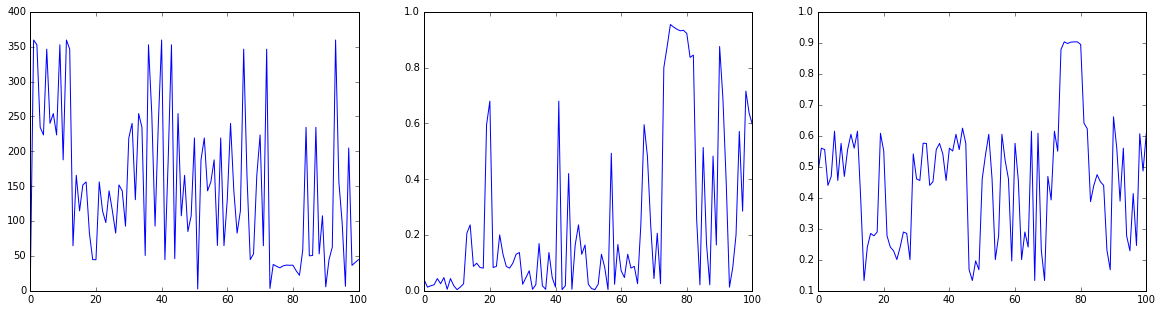

In [7]:
path_h = path_array(log_id, reduced_hsv[:,:,0])
path_s = path_array(log_id, reduced_hsv[:,:,1])
path_v = path_array(log_id, reduced_hsv[:,:,2])

path_normalized_h = normalize1d(path_h)
path_normalized_s = normalize1d(path_s)
path_normalized_v = normalize1d(path_v)
path_normalized_hsv = [path_normalized_h, path_normalized_s, path_normalized_v]

# plot hsv
fig = plt.figure(figsize=(20,5))
ax1, ax2, ax3 = fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133)
ax1.plot(path_h)
ax2.plot(path_s)
ax3.plot(path_v)

### musicize

In [8]:
is_cut_loop = 0
cut_loop_num = 1
is_loop = 0
keyname = "F_mj"
first_octave = 3 # ex: 0=[C0, C#0, ..., C1] for "all"
plus_octave = 1
key_id_shift = 0 # ex: 0=C=ド for "all"

first_time_ratio = 8
time_length_ratio = 12
isnt_degeneratable = 1
bpm = 150
loop_count = 8
len_id_usage = len(log_id)

bps = bpm/60
time_1count    = 1/bps
time_element   = time_1count/2
time_1loop       = loop_count*time_1count

unified_sound_wave, path_freq, path_first_time, path_time_length = path2wave(path_normalized_hsv, keyname, first_octave, plus_octave, key_id_shift, first_time_ratio, time_length_ratio, isnt_degeneratable, bpm, loop_count, len_id_usage, sr)
if is_cut_loop == 1:
    len_1loop = int(cut_loop_num*time_1loop*sr)
    unified_sound_wave = unified_sound_wave[0:len_1loop]
    path_freq                   = path_freq[0:len_1loop]
    path_first_time         = path_first_time[0:len_1loop]
    path_time_length     = path_time_length[0:len_1loop]

raw_unified_sound_wave = unified_sound_wave

whole_time_length = len(unified_sound_wave)/sr
print(len(unified_sound_wave))
print(time_1count, 'sec ', time_1loop, 'sec')
print(whole_time_length, 'sec')
print(whole_time_length/time_1count, ' counts')
print(whole_time_length/time_1loop, ' loop')

5785920
0.4 sec  3.2 sec
131.2 sec
327.99999999999994  counts
40.99999999999999  loop


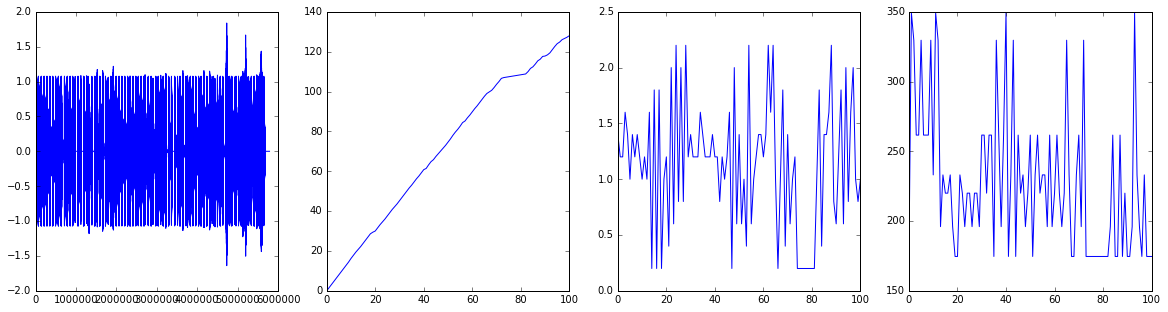

In [9]:
fig = plt.figure(figsize=(20,5))
ax1, ax2, ax3, ax4 = fig.add_subplot(141), fig.add_subplot(142), fig.add_subplot(143), fig.add_subplot(144)

#C3:130.81, B3:246.94, C4:261.63, B4:493.88, C5:523,25
ax1.plot(unified_sound_wave)
ax2.plot(path_first_time)
ax3.plot(path_time_length)
ax4.plot(path_freq)

In [10]:
if is_loop == 1:
    unified_sound_wave = np.array(int(len(unified_sound_wave_melody)/len(raw_unified_sound_wave) + 1)*list(raw_unified_sound_wave))
    unified_sound_wave_loop = unified_sound_wave    

max_amp = max(abs(unified_sound_wave))
print(max_amp)
unified_sound_wave = unified_sound_wave/max_amp
wavwrite(unified_sound_wave,"music_w"+str(partition_num_width)+"h"+str(partition_num_height)+".wav")

1.83914594582


In [11]:
img_prm = [partition_num_width, partition_num_height, last_path_order, first_shift, repeatable_num]
msc_prm = [is_cut_loop, cut_loop_num, is_loop, keyname, first_octave, plus_octave, key_id_shift, loop_count, first_time_ratio, time_length_ratio, isnt_degeneratable, bpm, len_id_usage]
prm_mldy = 'mldy_' + '-'.join(list(map(str, img_prm))) + '_' + '-'.join(list(map(str, msc_prm)))
prm_mldy

'mldy_10-10-100-1-3_0-1-0-F_mj-3-1-0-8-8-12-1-150-101'

In [12]:
log_id_melody = log_id
reduced_rgb_melody = reduced_rgb
reduced_hsv_melody = reduced_hsv

unified_sound_wave_melody = raw_unified_sound_wave
partition_num_width_melody = partition_num_width
partition_num_height_melody = partition_num_height

## loop part --------------------------------------------------
### image

In [13]:
partition_num_width = 3
partition_num_height = 3
last_path_order = 100
first_shift = 1
repeatable_num = 3

log_id, reduced_rgb, reduced_hsv = img2path(img, partition_num_width, partition_num_height, last_path_order, first_shift, repeatable_num)

(3, 3, 3)
(3, 3, 3)


In [14]:
print(log_id)
print(len(log_id))

[[1, 1], [1, 2], [2, 2], [2, 1], [1, 1], [1, 2], [2, 2], [0, 2], [1, 2], [2, 2], [0, 2], [0, 0], [0, 1], [1, 1], [1, 2], [2, 2], [0, 2], [1, 0], [1, 1], [2, 0]]
20


133


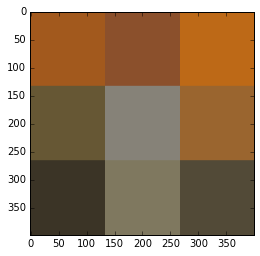

In [15]:
img_size = 400 # pixel
reduced_color_img = mk_reduced_color_img(img_size, partition_num_width, partition_num_height, log_id, reduced_rgb, "loop")
plt.imshow(reduced_color_img)

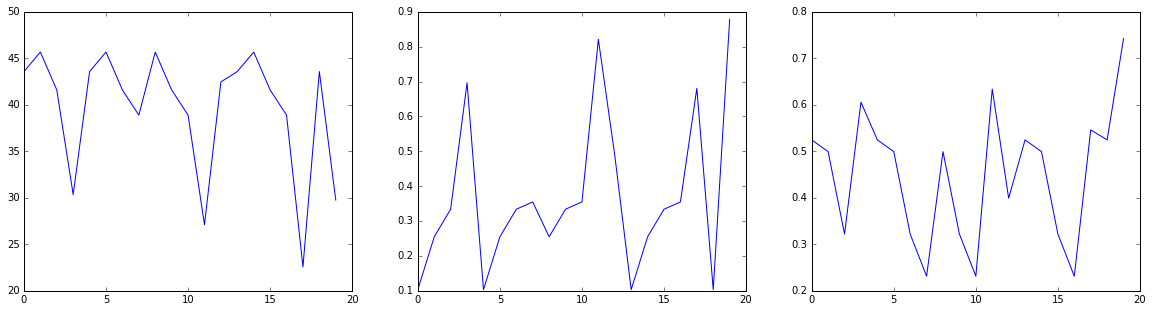

In [16]:
path_h = path_array(log_id, reduced_hsv[:,:,0])
path_s = path_array(log_id, reduced_hsv[:,:,1])
path_v = path_array(log_id, reduced_hsv[:,:,2])

path_normalized_h = normalize1d(path_h)
path_normalized_s = normalize1d(path_s)
path_normalized_v = normalize1d(path_v)
path_normalized_hsv = [path_normalized_h, path_normalized_s, path_normalized_v]

# plot hsv
fig = plt.figure(figsize=(20,5))
ax1, ax2, ax3 = fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133)
ax1.plot(path_h)
ax2.plot(path_s)
ax3.plot(path_v)

### musicize

In [17]:
is_cut_loop = 1
cut_loop_num = 1
is_loop = 1
keyname = "F_mj"
first_octave = 2 # ex: 0=[C0, C#0, ..., C1] for "all"
plus_octave = 1
key_id_shift = 0 # ex: 0=C=ド for "all"
loop_count = 4

first_time_ratio = 3
time_length_ratio = 12
isnt_degeneratable = 0
bpm = 150
len_id_usage = len(log_id)

bps = bpm/60
time_1count    = 1/bps
time_element   = time_1count/2
time_1loop       = loop_count*time_1count

unified_sound_wave, path_freq, path_first_time, path_time_length = path2wave(path_normalized_hsv, keyname, first_octave, plus_octave, key_id_shift, first_time_ratio, time_length_ratio, isnt_degeneratable, bpm, loop_count, len_id_usage, sr)
whole_time_length = len(unified_sound_wave)/sr
print(len(unified_sound_wave))
print(whole_time_length, 'sec')
if is_cut_loop == 1:
    len_1loop = int(cut_loop_num*time_1loop*sr)
    unified_sound_wave = unified_sound_wave[0:len_1loop]
    path_freq                   = path_freq[0:len_1loop]
    path_first_time         = path_first_time[0:len_1loop]
    path_time_length     = path_time_length[0:len_1loop]

raw_unified_sound_wave = unified_sound_wave

whole_time_length = len(unified_sound_wave)/sr
print(len(unified_sound_wave))
print(time_1count, 'sec ', time_1loop, 'sec')
print(whole_time_length, 'sec')
print(whole_time_length/time_1count, ' counts')
print(whole_time_length/time_1loop, ' loop')

352801
8.000022675736961 sec
70560
0.4 sec  1.6 sec
1.6 sec
4.0  counts
1.0  loop


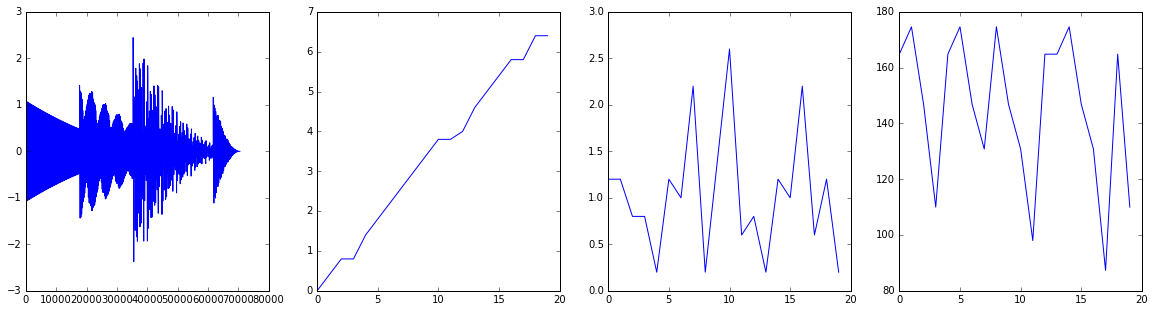

In [18]:
fig = plt.figure(figsize=(20,5))
ax1, ax2, ax3, ax4 = fig.add_subplot(141), fig.add_subplot(142), fig.add_subplot(143), fig.add_subplot(144)

#C3:130.81, B3:246.94, C4:261.63, B4:493.88, C5:523,25
ax1.plot(unified_sound_wave)
ax2.plot(path_first_time)
ax3.plot(path_time_length)
ax4.plot(path_freq)

In [19]:
if is_loop == 1:
    looped_unified_sound_wave = np.array(int(len(unified_sound_wave_melody)/len(raw_unified_sound_wave) + 1)*list(raw_unified_sound_wave))
    unified_sound_wave = looped_unified_sound_wave

max_amp = max(abs(unified_sound_wave))
print(max_amp)
unified_sound_wave = unified_sound_wave/max_amp
wavwrite(unified_sound_wave,"music_w"+str(partition_num_width)+"h"+str(partition_num_height)+".wav")

2.44494188711


In [20]:
img_prm = [partition_num_width, partition_num_height, last_path_order, first_shift, repeatable_num]
msc_prm = [is_cut_loop, cut_loop_num, is_loop, keyname, first_octave, plus_octave, key_id_shift, loop_count, first_time_ratio, time_length_ratio, isnt_degeneratable, bpm, len_id_usage]
prm_loop = 'loop_' + '-'.join(list(map(str, img_prm))) + '_' + '-'.join(list(map(str, msc_prm)))
prm_loop

'loop_3-3-100-1-3_1-1-1-F_mj-2-1-0-4-3-12-0-150-20'

In [21]:
log_id_loop = log_id
reduced_rgb_loop = reduced_rgb
reduced_hsv_loop = reduced_hsv

raw_unified_sound_wave_loop = raw_unified_sound_wave
unified_sound_wave_loop = looped_unified_sound_wave
partition_num_width_loop = partition_num_width
partition_num_height_loop = partition_num_height

## Mix melody and loop ---------------------------------------

In [22]:
unified_sound_wave = unify1d(1*unified_sound_wave_melody, 1*unified_sound_wave_loop)

In [23]:
max_amp = max(abs(unified_sound_wave))
print(max_amp)
unified_sound_wave = unified_sound_wave/max_amp
wavwrite(unified_sound_wave,"music_"+prm_mldy+"_"+prm_loop+"_"+img_name+".wav")

3.45665916154


In [24]:
end_whole_time = time.time()
elapsed_whole_time = end_whole_time - start_whole_time
print(elapsed_whole_time, "sec   ", elapsed_whole_time/60, "min   ", elapsed_whole_time/3600, "hour")

94.86606693267822 sec    1.581101115544637 min    0.026351685259077284 hour
